In [1]:
import math
import numpy as np
import random
import numpy.matlib
import matplotlib.pyplot as plt
import time
from datetime import datetime
import sys
import csv
import pandas as pd
from matplotlib import cm
import pandas as pd
from kneed import KneeLocator
from random import uniform
from random import randint
import xlsxwriter
import warnings
from numpy import sin, cos, pi, linspace
from collections import OrderedDict
from SPGA import SPGA
import tkinter as tk
from mpl_toolkits.mplot3d import axes3d
import xlsxwriter

import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [7]:
Area = {
    "x" : 0.0,
    "y" : 0.0,
    "z" : 0.0
}
Area2 = {
    "x" : 0.0,
    "y" : 0.0,
    "z" : 0.0
}
Model = {
    "n" : 0,
    "Sinkx" : 0.0,
    "Sinky" : 0.0,
    "Sinkz" : 0.0,
    "BsX" : 0.0,
    "BsY" : 0.0,
    "BsZ" : 0.0,
    "SinkEnergy" : math.inf,
    "p" : 0.1,
    "Eo" : 2.0,
    "ETX" : 50 * 0.000000001,
    "ERX" : 50 * 0.000000001,
    "Efs" : 10*0.000000000001,
    "Emp" : 0.0013*0.000000000001,
    "EDA" : 5*0.000000001,
    "do" : 0.0,
    "rmax" : 70000,
    "DpacketLen" : 4000,
    "HpacketLen" : 100,
    "NumPacket" : 10, # buffer in sensor
    "RR" : 0.0,
    "SinkRR" : 0.0
}
EmptySensor = {
    "xd" : 0,
    "yd" : 0,
    "G" : 0,
    "df" : 0,
    "type" : 'N',
    "E" : 0,
    "id" : 0,
    "dis2sink": 0,
    "dis2ch" : 0,
    "MCH" : Model["n"]    #%Member of CH
}
Sensors = []
#########################################################################################################################
def save_DS_in_xlsx(file, X, Y, Z, names):
    workbook = xlsxwriter.Workbook(file)

    # By default worksheet names in the spreadsheet will be Sheet1, Sheet2 etc., but we can also specify a name.
    worksheet = workbook.add_worksheet("My sheet")

    # Start from the first cell. Rows and columns are zero indexed.
    row = 1
    col = 0
    worksheet.write('A1', 'Name')
    worksheet.write('B1', 'X')
    worksheet.write('C1', 'Y')
    worksheet.write('D1', 'Z')

    # Iterate over the data and write it out row by row.
    for i in range(len(names)):
        worksheet.write(row, col, names[i])
        worksheet.write(row, col + 1, X[i])
        worksheet.write(row, col + 2, Y[i])
        worksheet.write(row, col + 3, Z[i])
        row += 1
    workbook.close()
#########################################################################################################################
def setParameters(n):
    #*************** update here area & sink *****************
    #Area["x"] = 100 #normalizeRange(0, 100, 0, 0.1, n)
    #Area["y"] = 100 #normalizeRange(0, 100, 0, 0.1, n)
    #
    #Sink Motion pattern 
    #Sinkx = 50 #Area["x"] # 0.5 * Area["x"]
    #Sinkx = normalizeRange(0, 100, 0, 0.1, Sinkx)
    #Sinky = 50 # Area["y"] # 0.5 * Area["y"]
    
    # base station
    #bs_X = 400
    #bs_y = 150
    #bs = [bs_X, bs_y, 0]
    #Optimal Election Probability of a node to become cluster head
    p = 0.1
    
    #%%%%%%%%%%%%%%%%%%%%%%%%% Energy Model (all values in Joules)%%%%%%%%%%%
    #Initial Energy 
    Eo = 2.0 #0.5

    #Eelec=Etx=Erx
    ETX = 50 * 0.000000001
    ERX = 50 * 0.000000001

    #Transmit Amplifier types
    Efs = 10*0.000000000001 
    Emp = 0.0013*0.000000000001

    #Data Aggregation Energy
    EDA=5*0.000000001

    #Computation of do
    do=math.sqrt(Efs/Emp)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%% Run Time Parameters %%%%%%%%%%%%%%%%%%%%%%%%%
    #maximum number of rounds
    rmax=70000

    #Data packet size
    DpacketLen=4000

    #Hello packet size
    HpacketLen=100

    #Number of Packets sended in steady-state phase
    NumPacket=10

    #Redio Range
    RR = 100 # meters #0.5*Area["x"]*math.sqrt(2)
    #RR = normalizeRange(0, 100, 0, 0.1, RR)
    SinkRR = 1000 # meters
    
    #%%%%%%%%%%%%%%%%%%%%%%%%% Save in Model %%%%%%%%%%%%%%%%%%%%%%%%%%%%
    Model["n"]=n
    #Model["Sinkx"]=Sinkx
    #Model["Sinky"]=Sinky
    #Model["BsX"] = bs_X
    #Model["BsY"] = bs_y
    Model["p"]=p
    Model["Eo"]=Eo
    Model["ETX"]=ETX
    Model["ERX"]=ERX
    Model["Efs"]=Efs
    Model["Emp"]=Emp
    Model["EDA"]=EDA
    Model["do"]=do
    Model["rmax"]=rmax
    Model["DpacketLen"]=DpacketLen
    Model["HpacketLen"]=HpacketLen
    Model["NumPacket"]=NumPacket
    Model["RR"]=RR
    Model["SinkRR"] = SinkRR
#########################################################################################################################
def CreateRandomSen():
    n = Model["n"]
    x = Area["x"]
    y = Area["y"]
    X = np.random.random_sample(size = n)*x
    return X, Y
#########################################################################################################################
def ConfigureSensors(n, GX, GY):
    ## Configuration Sensors
    Sensors = [{"xd" : 0,
    "yd" : 0,
    "G" : 0,
    "df" : 0,
    "type" : 'N',
    "E" : 0,
    "id" : 0,
    "dis2sink": 0,
    "dis2ch" : 0,
    "MCH" : n } for i in range(n+1)]
    #Sensors = np.matlib.repmat(EmptySensor,n+1,1)
    for i in range(n):
        #set x location
        Sensors[i]["xd"] = GX[i]#[0]
        #set y location
        Sensors[i]["yd"] = GY[i]#[0]
        #Determinate whether in previous periods has been clusterhead or not? not=0 and be=n
        Sensors[i]["G"] = 0
        #dead flag. Whether dead or alive S(i).df=0 alive. S(i).df=1 dead.
        Sensors[i]["df"] = 0
        #initially there are not each cluster heads
        Sensors[i]["type"] = 'N'
        #initially all nodes have equal Energy
        Sensors[i]["E"] = Model["Eo"]
        #id
        Sensors[i]["id"] = i
        Sensors[i]["RR"]=Model["RR"]
    Sensors[n]["xd"] = Model["Sinkx"]
    Sensors[n]["yd"] = Model["Sinky"]
    Sensors[n]["E"] = Model["SinkEnergy"]
    Sensors[n]["id"] = n
    Sensors[n]["RR"]=Model["SinkRR"]
    Sensors[n]["type"] = 'GW' #'BS'
    return Sensors
#########################################################################################################################
def saveStatistics(file, typeBS, STATISTICS):
    workbook = xlsxwriter.Workbook(file)
    worksheet = workbook.add_worksheet(typeBS)
    # By default worksheet names in the spreadsheet will be Sheet1, Sheet2 etc., but we can also specify a name.
    row = 0
    col = 0

    worksheet.write(row, col, "Type BS")
    worksheet.write(row+1, col, typeBS)
    col += 1
    
    for j,statis in enumerate(STATISTICS):
        worksheet.write(row, col, statis)
        for i,val in enumerate(STATISTICS[statis]):
            worksheet.write(row+i+1, col, val)
        col += 1

    workbook.close()
    #print("Done!")
#########################################################################################################################
def ploter(nodes, plotFlag):
    fig, ax = plt.subplots(figsize=(6, 6))
    deadNum = 0
    m = len(nodes)
    if plotFlag == "Yes":
        for i in range(m):
            #check dead node
            if (nodes[i]["E"] > 0):
                if (nodes[i]["type"] == 'N'):
                    plt.plot(nodes[i]["xd"],nodes[i]["yd"],'o', color = 'blue', label = nodes[i]["id"])
                    plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))
                    pass
                elif nodes[i]["type"] == 'C':
                    plt.plot(nodes[i]["xd"],nodes[i]["yd"],'x', color = 'green', label = nodes[i]["id"])
                    plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))
                    pass
                else:
                    plt.plot(nodes[i]["xd"],nodes[i]["yd"],'*', color = 'black', label = nodes[i]["id"])
                    plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))
                    pass
            else:
                deadNum = deadNum + 1
                plt.plot(nodes[i]["xd"],nodes[i]["yd"], '.', color = 'red', label = nodes[i]["id"])
                plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))
            
        # draw lines
        for i,s in enumerate(nodes):
            if s["E"] > 0:
                x1 = s["xd"]
                y1 = s["yd"]
                x2 = nodes[s["MCH"]]["xd"]
                y2 = nodes[s["MCH"]]["yd"]
                if s["type"] == 'N' and nodes[s["MCH"]]["type"] == 'N':
                    col = 'black'
                    listy = '--'
                elif s["type"] == 'N' and nodes[s["MCH"]]["type"] == 'C':
                    col = 'gray'
                    listy = ':'
                elif s["type"] == 'N' and nodes[s["MCH"]]["type"] == 'GW': #'BS'
                    col = 'black'
                    listy = '-.'
                elif s["type"] == 'C' and nodes[s["MCH"]]["type"] == 'C':
                    col = 'red'
                    listy = ':'
                elif s["type"] == 'C' and nodes[s["MCH"]]["type"] == 'GW': #'BS'
                    col = 'green'
                    listy = '-.'
                else:
                    col = 'yellow'
                    listy = '--'
                plt.plot([x1, x2], [y1, y2], linestyle = listy, color=col)
        plt.ylim([0, Area["y"]])
        plt.xlim([0, Area["x"]])
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()
        #plt.axis('square')
    else:
        for i in range(m):
            #check dead node
            if (nodes[i]["E"] < 0):
                deadNum = deadNum + 1
    return deadNum
#########################################################################################################################
def normalizeRange(OldMin, OldMax, NewMin, NewMax, OldValue):
    OldRange = (OldMax - OldMin)
    if OldRange == 0:
        NewValue = NewMin
    else:
        NewRange = (NewMax - NewMin)  
        NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
    return NewValue
#########################################################################################################################
def SendReceivePackets(nodes ,Sender ,PacketType ,Receiver): 
    lsrp = 0
    lrrp = 0
    lsdp = 0
    lrdp = 0
    lsap = 0   #  % Send a packet
    lrap = 0   # % Receive a packet
    cntrCH = 0
    cntrBS = 0
    if (str(PacketType) == str('Hello')):
        PacketSize = Model["HpacketLen"]
    else:
        PacketSize = Model["DpacketLen"]
    
    #Energy dissipated from Sensors for Send a packet
    if type(Sender) is list:
        senderLoop = Sender
    else:
        senderLoop = [Sender]
    
    if type(Receiver) is list:
        for r in Receiver:
            if r == Sensors[-1]["id"]: # remove sink from receiving
                Receiver.remove(r)
        receiverLoop = Receiver
    else:
        receiverLoop = [Receiver]
    #print('Sender', senderLoop)
    #print('Receiver ', receiverLoop)
    #---- Sending process
    for snd in senderLoop: #len(Sender)
        for j in receiverLoop:
            if snd != j:
                #print("Distance between ", snd, "(",Sensors[snd]["xd"],",",Sensors[snd]["yd"],") and ", j,"(",Sensors[j]["xd"],",",Sensors[j]["yd"],"): ")
                distance = np.sqrt(np.square(Sensors[snd]["xd"] - Sensors[j]["xd"]) + np.square(Sensors[snd]["yd"] - Sensors[j]["yd"]))
                #print("\t\tD = ", distance)
                for n in nodes:
                    if n["id"] == snd:
                        if (distance > Model["do"]):                    
                            n["E"] = n["E"] - (Model["ETX"] * PacketSize + Model["Emp"] * PacketSize * (distance ** 4))                    
                        else:
                            n["E"] = n["E"] - (Model["ETX"] * PacketSize + Model["Efs"] * PacketSize * (distance ** 2))
                        # Sent a packet
                        if (n["E"] > 0):
                            lsap = lsap + 1 # # increase number of sent packets
                    
    
    # ------ Receiving process
    #Energy dissipated from sensors for Receive a packet    
    for i in senderLoop:#len(Sender)
        for j in receiverLoop:
            #Received a Packet
            for n in nodes:
                if n["id"] == j:
                    if (n["E"] > 0): # Sensors[i]["E"] > 0 and
                        n["E"] = n["E"] - ((Model["ERX"] + Model["EDA"]) * PacketSize)
                        lrap = lrap + 1   # increase number of recieve packets
                        if n["type"] == 'C':
                            cntrCH = cntrCH + 1 # increase number of sent packets to CH
                        elif n["type"] == 'GW': #'BS'
                            cntrBS = cntrBS + 1 # increase number of sent packets to BS
    if (str(PacketType) == str('Hello')):
        lsrp = lsrp + lsap
        lrrp = lrrp + lrap
    else:
        lsdp = lsdp + lsap
        lrdp = lrdp + lrap

    return nodes,lsrp,lrrp,lsdp,lrdp,cntrBS,cntrCH
#########################################################################################################################
def disToSink(nodes): 
    n = Model["n"] # sink = n
    m = len(nodes)
    for i in range(m):
        distance = np.sqrt(np.square(nodes[i]["xd"] - nodes[n]["xd"]) + np.square(nodes[i]["yd"] - nodes[n]["yd"]))
        nodes[i]["dis2sink"] = distance
        #print("Sensors[",i,"]['xd']:",Sensors[i]["xd"], "Sensors[",i,"]['yd']:",Sensors[i]["yd"], "\tdis2sink: ", Sensors[i]["dis2sink"])
        for s in Sensors:
            if s["id"] == i:
                s["dis2sink"] = nodes[i]["dis2sink"]
    return nodes
#########################################################################################################################
def resetSensors(nodes): 
    m = len(nodes)
    for i in range(m-1):
        if nodes[i]["type"] != 'GW': #'BS'
            nodes[i]["G"] = 0
            nodes[i]["df"] = 0
            nodes[i]["E"] = Model["Eo"]
            nodes[i]["MCH"] = m-1
            nodes[i]["type"] = 'N'
            nodes[i]["dis2sink"] = math.inf
            nodes[i]["dis2ch"] = math.inf
            nodes[i]["RR"] = Model["RR"] #normalizeRange(0, 100, 0, 0.1, 100)
    return nodes
#########################################################################################################################
def resetSensorsLEACH(nodes):
    m = len(nodes)
    print('m: ', m)
    for node in nodes:
        node["MCH"] = m-1
        node["type"] = 'N'
        node["dis2sink"] = math.inf
        node["dis2ch"] = math.inf
    return nodes
#########################################################################################################################
def resetType(nodes):
    for node in nodes:
        if node["type"] != 'GW': #'BS'
            node["type"] = 'N'
            node["MCH"] = nodes[-1]["id"]
            for sen in Sensors:
                if node["id"] == sen["id"]:
                    sen["type"] = node["type"]
                    sen["MCH"] = node["MCH"]
    return nodes
#########################################################################################################################
def SelectCH(nodes, r): ##### LEACH ######
    CH = [] # sequence of Sensors' indecs which are CH
    countCHs = 0
    n = Model["n"] # number of nodes
    m = len(nodes)-1
    for i, node in enumerate(nodes):
        if node["E"] > 0 and node["G"] <= 0:
            temp_rand = np.random.uniform(0.0, 1.0)
            #Election of Cluster Heads
            if (temp_rand <= (Model["p"] / (1 - Model["p"] * np.mod(r,np.round(1 / Model["p"]))))):
                countCHs = countCHs + 1
                CH.append(node)
                #CH[countCHs]["id"] = i
                # CH.append(Sensors[i]["id"])
                #Sensors[countCHs]["id"] = i
                node["type"] = 'C'
                node["G"] = np.round(1 / Model["p"]) - 1
    return CH,nodes
#########################################################################################################################
def KmeansSelectCH(samples, nodes, R, center, maxField):
    period = 1
    distortions = []
    distances = []
    indx_centroids = [] # contain the indecis of centroids in samples
    realCentroids = []
    old_n_cluster = 0
    # run K-means algorithm
    for itr in range(0, period):
        #print('\n========== Round  %d/%d ============' % (itr, period))
        n_clusters, optimal_cost, nodes_in_clusters, centroids = optimalK(samples, int(samples.shape[0]), R, center, maxField)
        if n_clusters == None:
            n_clusters = old_n_cluster-1
        else:
            old_n_cluster = n_clusters
        #while n_clusters is None:
        #    n_clusters = optimalK(samples, int(samples.shape[0]/2))
        #print("Оптимальное количество кластеров K = ", n_clusters)
        current_centroids = init_centroids(samples, n_clusters, R, center, Model["n"])
        cost_clustering, members, crnt_centroids = run_k_means(samples, current_centroids, n_clusters, True, 1, False, R)
        distortions.append(cost_clustering)
        for c in crnt_centroids:
            if np.array(c) in samples:
                indx_centroids.append(np.where(samples == np.array(c)))
        minm = 0.0
        index_min_dis = 0
        for centroid in crnt_centroids:
            distances.clear()
            for sensor in samples:
                ds = np.sqrt((centroid[0]-sensor[0])** 2 + (centroid[1]-sensor[1])**2 + (centroid[2]- sensor[2])**2)
                distances.append(ds)
            minm = distances[0]
            index_min_dis = 0   
            for idx, dis in enumerate(distances):
                if(dis < minm and nodes[idx]["E"] > 0):
                    minm = dis
                    index_min_dis = idx
            realCentroids.append(index_min_dis)
    # configure ch nodes
    for ch in realCentroids:
        if nodes[ch]["E"] > 0:
            nodes[ch]["type"] = 'C'

    # configure members of CHs
    for i, ch in enumerate(realCentroids):
        for idm, mem in enumerate(members[i]):
            if nodes[idm]["E"] > 0 and nodes[idm]["id"] != 'GW': #'BS'
                nodes[mem]["MCH"] = nodes[ch]["id"]
                nodes[mem]["dis2ch"] = np.sqrt(np.square(nodes[mem]["xd"] - nodes[ch]["xd"]) + np.square(nodes[mem]["yd"] - nodes[ch]["yd"]))
            elif nodes[idm]["E"] <= 0:
                nodes[mem]["MCH"] = nodes[mem]["id"]
                nodes[mem]["dis2ch"] = 0
    
    # apply changes to Sensors
    for node in nodes:
        for s in Sensors:
            if node["id"] == s["id"]:
                s["type"] = node["type"]
                s["MCH"] = node["MCH"]
                s["dis2ch"] = node["dis2ch"]
    return realCentroids, members, nodes
#########################################################################################################################
def findReceiver(nodes ,Sender ,SenderRR): 
    Receiverls = []
    m = len(nodes)
    #D = np.zeros((1,m))[0]
    D = np.zeros(m)
    #print('node sender x,y: ', nodes[Sender]["xd"], nodes[Sender]["yd"])
    for i, node in enumerate(nodes):
        #print('receiver: ', node["id"], ' (', node["xd"], ',', node["yd"], ')')
        D[i] = np.sqrt((node["xd"] - nodes[Sender]["xd"])**2 + (node["yd"] - nodes[Sender]["yd"])**2)
    for i in range(m):
        if (D[i] <= SenderRR and Sender != nodes[i]["id"] and nodes[i]["E"] > 0):
            Receiverls.append(nodes[i]["id"])
    return Receiverls
#########################################################################################################################
def JoinToNearestCH(nodes, TotalCH): # TotalCH = [Sensor1, Sensor2, ...]
    n = Model["n"]
    nn = len(nodes)-1
    m = len(TotalCH)
    if (m >= 1):
        D = np.zeros((m,nn))
        #print("D:", D)
        for i in range(nn):
            for j in range(m):
                x = np.square(nodes[i]["xd"] - nodes[TotalCH[j]["id"]]["xd"])
                #print("x:", x)
                y = np.square(nodes[i]["yd"] - nodes[TotalCH[j]["id"]]["yd"])
                #print("y:", y)
                D[j,i] = np.sqrt(x + y)
        ##
        idx = []
        Dmin = np.amin(D, axis = 0)# min value for each colmun أصغر قيمة لكل عمود
        for d in Dmin:
            idx.append(np.where(D == d)[0][0]) # first [0] determin index of min value that place in rows تحدد الصف الذي تقع فيه أصغر قيمة
        idx = np.array(idx)
        
        for i in range(nn):
            if (nodes[i]["E"] > 0):
                #if node is in RR CH and is Nearer to CH rather than Sink
                if (Dmin[i] <= Model["RR"] and Dmin[i] < nodes[i]["dis2sink"]):
                    nodes[i]["MCH"] = TotalCH[idx[i]]["id"]
                    nodes[i]["dis2ch"] = Dmin[i]
                else:
                    nodes[i]["MCH"] = nn
                    nodes[i]["dis2ch"] = nodes[i]["dis2sink"]
    else:
        Senders = findSender(nodes ,TotalCH[0])
        for i,node in enumerate(nodes):
            for send in Senders:
                if node["id"] == send:
                    node["MCH"] = TotalCH[0]
                    node["dis2ch"] = np.sqrt(np.square(node["xd"] - nodes[TotalCH[0]["id"]]["xd"]) + np.square(node["yd"] - nodes[TotalCH[0]["id"]]["yd"]))
            
    return nodes
#########################################################################################################################
def findSender(nodes ,Receiver): 
    Sender = []
    for i, node in enumerate(nodes):
        if node["MCH"] == Receiver and node["id"] != Receiver:
            Sender.append(node["id"])
    return Sender
#########################################################################################################################
def run_k_means(samples, current_centroids, n_clusters, plot_status, iteration, iteration_status, R):
    epsilon = 0.1
    new_centroids = np.zeros(shape=[n_clusters, 3])
    
    start_time = time.time()
    # loop until forming clusters and centroid points not changed
    while True:          
        costCh2Ch = 0
        # calculate distances between points and centroids        
        distances = []
        points_in_cluster = [] # c(i)
        for i,sample in enumerate(samples):
            distances = np.sqrt(np.sum((sample - current_centroids)**2, axis=1)) #- np.sqrt(samples.shape[0])*R
            # add sample/node that falls within radio visibility of cluster
            idx_cluster = np.argmin(distances)
            if distances[idx_cluster] <= R:
                points_in_cluster.append(idx_cluster)
            else:
                points_in_cluster.append(-1)

        # add points to corresponding cluster  u_c(i)      
        clusters = []
        if points_in_cluster != []:
            for index_cluster in range(0,n_clusters):
                clusters.append([])
                for index_point in range(0,len(points_in_cluster)):
                    if index_cluster == points_in_cluster[index_point]:
                        clusters[index_cluster].append(index_point)

        U_c = np.zeros(shape=[len(samples),3])
        if points_in_cluster != []:
            for i, i_clstr in enumerate(points_in_cluster):
                if i_clstr != -1:
                    U_c[i] = current_centroids[i_clstr]
        indxPointsNonInClusters = np.where(points_in_cluster == -1)[0]
        additionalCost = 0
        if indxPointsNonInClusters.shape[0] > 0:
            for i, p in enumerate(indxPointsNonInClusters):
                minVal = 1000
                minIndx = -1
                for j, cntr in enumerate(current_centroids):
                    dd = np.sqrt(np.sum((samples[p] - cntr)**2))
                    if dd < minVal:
                        minVal = dd
                        minIndx = j
                additionalCost += minVal
        # update centroids
        for i_cluster in range(0, n_clusters):           
            pointsCluster = []
            if clusters[i_cluster] != []: # include nodes that fall into a cluster
                for point in clusters[i_cluster]:
                    pointsCluster.append(samples[point,:])
            else:
                pointsCluster.append(np.zeros(3))
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                new_centroids[i_cluster] = np.array(pointsCluster).mean(axis = 0)
        # stop condition
        if np.all(np.abs(current_centroids - new_centroids) <= epsilon):
            break
        
        # created centroids become the current centroids of the next iteration
        current_centroids = np.array(new_centroids)      

    # calculate distortion
    cost_sample2ch = np.sum(np.sum((samples - U_c)**2, axis=0) / samples.shape[0])
    #cost_ch2ch = np.sum(np.sum((current_centroids - U_c_c)**2, axis=0) / current_centroids.shape[0])
    cost = cost_sample2ch + additionalCost #+ cost_ch2ch #- (np.sqrt(n_clusters) * R)
    return cost, clusters, current_centroids
#########################################################################################################################
def elbow_method(J_costs, max_clusters):
    axis_x_clusters = []
    for w in range(1, max_clusters+1):
        axis_x_clusters.append(w)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        knInc = KneeLocator(axis_x_clusters, J_costs, curve='convex', direction='decreasing', S=2.0)    # concave for knee
        elbow_point_inc = knInc.elbow # kn.knee
    return elbow_point_inc
#########################################################################################################################
def init_centroids(X, n_clusters, r, center, maxX): 
    centroids = np.empty(shape=(n_clusters,3))
    ang = 0
    for i in range(1,n_clusters):
        ang += (2*pi/(n_clusters))
        centroids[i,0] = (maxX/4) * cos(ang) + center
        centroids[i,1] = (maxX/4) * sin(ang) + center
        centroids[i,2] = 0
    return centroids
#########################################################################################################################
def optimalK(samples, max_clusters, R, center, maxField):
    opt_k = int(np.round(0.977 * np.sqrt(samples.shape[0])))
    current_centroids = init_centroids(samples, opt_k, R, center, maxField)
    cost_clustering, pnts_in_cluster, crnt_centroids = run_k_means(samples, current_centroids, opt_k, False, 0, True, R)
    return opt_k, cost_clustering, pnts_in_cluster, crnt_centroids
#########################################################################################################################
def distance( u1, u2):
    return math.sqrt((u2[0]-u1[0])** 2 + (u2[1]-u1[1])**2 + (u2[2]- u1[2])**2)
#########################################################################################################################
def readData(file):
    samples_file = pd.read_excel(file)
    X_colmun = [x for x in samples_file.keys() if x.startswith('X')]
    x = samples_file[X_colmun].values
    Y_colmun = [x for x in samples_file.keys() if x.startswith('Y')]
    y = samples_file[Y_colmun].values
    Z_colmun = [x for x in samples_file.keys() if x.startswith('Z')]
    z = samples_file[Z_colmun].values
    return x,y,z
#########################################################################################################################
########### Hopfield ###########
def kronecker_delta(x, y):
    if x == y:
        return 1
    return 0

class Hopfield1:
    def __init__(self, cities, d, alpha):
        self.cities = cities
        self.neurons = cities**2
        self.alpha = alpha
        self.distance = d

        self.w = np.zeros([self.neurons, self.neurons])

    def normalizacja(self, x):                  #normalizacja wartości zmiany pojedynczego neuronu
        return 0.5*(1.0+np.tanh(self.alpha*x))

    def training(self, u, A, B, C, D, sigma):   #główna funkcja trenujący
        n = self.cities

        for iteration in range((n**2)):
            x = randint(0, n - 1)
            i = randint(0, n - 1)
            tmpA = 0
            for j in range(n):
                if i != j:
                    tmpA += u[x][j]
            tmpA *= -A
            tmpB = 0
            for y in range(n):
                if x != y:
                    tmpB += u[y][i]
            tmpB *= -B
            tmpC = 0
            for y in range(n):
                for j in range(n):
                    tmpC += u[y][j]
            tmpC -= (n+sigma)
            tmpC *= -C
            tmpD = 0
            for y in range(n):
                if 0 < i < n - 1:
                    tmpD += self.distance[x][y] * (u[y][i + 1] + u[y][i - 1])
                elif i > 0:
                    tmpD += self.distance[x][y] * (u[y][i - 1])
                elif i < n-1:
                    tmpD += self.distance[x][y] * (u[y][i + 1])
            tmpD *= -D
            u[x][i] = self.normalizacja(tmpA + tmpB + tmpC + tmpD)
        return u

    def modifyU(self, A, B, C, D, sigma, iterations):       #Obliczanie macierzy u
        u = np.zeros([self.cities, self.cities])
        for i in range(self.cities):
            for j in range(self.cities):
                u[i][j] = uniform(0, 0.03)

        lastDifference = self.calcDifference(u, A, B, C, D, sigma)
        repeated = 0
        max_repeat = 10                                     #liczba iteracji bez zmiany macierzy u (przerwanie po przekroczeniu)
        for iteration in range(iterations):
            u = self.training(u, A, B, C, D, sigma)
            error = self.calcDifference(u, A, B, C, D, sigma)
            if error == lastDifference:
                repeated += 1
            else:
                repeated = 0

            if repeated > max_repeat:
                break
            lastDifference = error
        return u

    def calcDifference(self, u, A, B, C, D, sigma):     #Obliczenie funkcji celu (E(x))
        tmpA = 0
        n = self.cities
        for x in range(n):
            for i in range(n):
                for j in range(n):
                    if i != j:
                        tmpA += u[x][i]*u[x][j]
        tmpA *= (A/2.0)

        tmpB = 0
        for i in range(n):
            for x in range(n):
                for y in range(n):
                    if x != y:
                        tmpB += u[x][i] * u[y][i]
        tmpB *= (B/2.0)

        tmpC = 0
        for x in range(n):
            for i in range(n):
                tmpC += u[x][i]
        tmpC -= 10
        tmpC = tmpC*tmpC
        tmpC *= (C/2.0)

        tmpD = 0
        for x in range(n):
            for y in range(n):
                for i in range(n):
                    if 0 < i < n - 1:
                        tmpD += self.distance[x][y] * u[x][i] * (u[y][i + 1] + u[y][i - 1])
                    elif i > 0:
                        tmpD += self.distance[x][y] * u[x][i] * (u[y][i - 1])
                    elif i < n - 1:
                        tmpD += self.distance[x][y] * u[x][i] * (u[y][i + 1])
        tmpD *= (D/2.0)
        return tmpA+tmpB+tmpC+tmpD

class Hopfield:
    def __init__(self, UAVS, d, alpha):
        self.UAVS = UAVS
        self.neurons = UAVS**2
        self.d = d
        self.alpha = alpha

        self.w = np.zeros([self.neurons, self.neurons])

        self.x_to_index = {}
        self.index_to_x = {}

        cnt = 0
        for i in range(UAVS):
            for j in range(UAVS):
                self.index_to_x[cnt] = (i, j)
                self.x_to_index[(i, j)] = cnt
                cnt += 1

    def train(self, A, B, C, D):
        n = self.UAVS
        for i in range(n):
            for a in range(n):
                for j in range(n):
                    for b in range(n):
                        wc = -C
                        wa = -A*(1-kronecker_delta(a, b))*kronecker_delta(i, j)
                        wb = -B*(1-kronecker_delta(i, j))*kronecker_delta(a, b)
                        wd = -D*self.d[i][j]*(1-kronecker_delta(i, j))*(kronecker_delta(a-1, b) + kronecker_delta(a+1, b))

                        self.w[self.x_to_index[(i, a)]][self.x_to_index[(j, b)]] = wa + wb + wc + wd

    def predict(self, A, B, C, D, max_iterations):
        self.train(A, B, C, D)

        u = np.zeros([self.neurons, 1])
        for i in range(self.UAVS):
            for j in range(self.UAVS):
                u[i][0] = 0.03 #uniform(-0.0002, 0.0002)#0, 0.03)

        prev_error = self.calc_error(u, A, B, C, D)
        repeated = 0
        max_repeat = 10
        for iteration in range(max_iterations):
            print('\t\t itr:', iteration)
            u = self.update(u, C)
            error = self.calc_error(u, A, B, C, D)
            if error == prev_error:
                repeated += 1
            else:
                repeated = 0

            if repeated > max_repeat:
                break
            prev_error = error
        ret = np.zeros([self.UAVS, self.UAVS])
        for i in range(self.UAVS):
            for j in range(self.UAVS):
                ret[i][j] = u[self.x_to_index[(i, j)]][0]

        return ret

    def update(self, u, C):
        # update is done asynchronously
        # to make update synchronous replace C*(n+1) with a bias vector containing C*(n+sigma)
        n = self.UAVS
        for iteration in range(5*n**2):
            i = randint(0, n-1)
            x = randint(0, n-1)
            u[self.x_to_index[(i, x)]][0] = self.f(np.dot(u.transpose(), self.w[:, self.x_to_index[(i, x)]]) + C*(n+1))
        return u

    def f(self, x):
        return 0.5*(1+np.tanh(self.alpha*x))

    def calc_error(self, u, A, B, C, D):
        tmpA = 0
        n = self.UAVS
        for i in range(n):
            for a in range(n):
                for b in range(n):
                    if a != b:
                        tmpA += u[self.x_to_index[(i, a)]][0] * u[self.x_to_index[(i, b)]][0]
        tmpA *= (A/2.0)

        tmpB = 0
        for i in range(n):
            for j in range(n):
                for a in range(n):
                    if i != j:
                        tmpB += u[self.x_to_index[(i, a)]][0] * u[self.x_to_index[(j, a)]][0]
        tmpB *= (B/2.0)

        tmpC = 0
        for i in range(n):
            for a in range(n):
                tmpC += u[self.x_to_index[(i, a)]][0]
        tmpC = (tmpC - n)**2
        tmpC *= (C/2.0)

        tmpD = 0
        for i in range(n):
            for j in range(n):
                for a in range(n):
                    if 0 < a < n-1:
                        tmpD += self.d[i][j]*u[self.x_to_index[(i, a)]][0]*(u[self.x_to_index[(j, a+1)]][0] + u[self.x_to_index[(j, a-1)]][0])
                    elif a > 0:
                        tmpD += self.d[i][j]*u[self.x_to_index[(i, a)]][0]*(u[self.x_to_index[(j, a-1)]][0] + u[self.x_to_index[(j, 0)]][0])
                    elif a < n-1:
                        tmpD += self.d[i][j]*u[self.x_to_index[(i, a)]][0]*(u[self.x_to_index[(j, a+1)]][0] + u[self.x_to_index[(j, n-1)]][0])
        tmpD *= (D/2.0)

        return tmpA + tmpB + tmpC + tmpD
#########################################################################################################################
def calc_d1(UAVS, R):
    n = UAVS.shape[0]
    d = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp_d = np.sqrt(np.square(UAVS[i][0] - UAVS[j][0]) + np.square(UAVS[i][1] - UAVS[j][1]))
            if temp_d > R: #100
                d[i][j] = temp_d * 2 # out of range
            else:
                 d[i][j] = temp_d # in radio vision another node
    #print('d in calc_d1', d)
    return d

def calc_d(UAVS, sink, R):
    n = UAVS.shape[0]
    d = np.zeros([n, n])
    for i in range(n):
        temp_d_1 = np.sqrt(np.square(UAVS[i][0] - sink[0]) + np.square(UAVS[i][1] - sink[1]))
        for j in range(n):
            temp_d_2 = np.sqrt(np.square(UAVS[i][0] - UAVS[j][0]) + np.square(UAVS[i][1] - UAVS[j][1]))
            if temp_d_2 > R: #100
                d[i][j] = temp_d_1 + temp_d_2 * 2 # out of range
            else:
                 d[i][j] = temp_d_1 + temp_d_2 # in radio vision another node
    #print('d in calc_d', d)
    return d

def calc_d2(UAVS, sink, R):
    n = UAVS.shape[0]
    d = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            d[i][j] = np.sqrt(np.square(UAVS[i][0] - UAVS[j][0]) + np.square(UAVS[i][1] - UAVS[j][1]))
    #print('d in calc_d', d)
    return d
#########################################################################################################################
def normalizeArray(uavs):
    maxValue = np.max(uavs)
    uav_norm = uavs / 1000
    return uav_norm
#########################################################################################################################
def set_UAVS(nodes, chs): # chs is alist of indecis' CHs in Sensors
    n = len(chs)
    uav = np.zeros([n, 2])
    for i,ch in enumerate(chs):
        uav[i] = (nodes[ch]["xd"], nodes[ch]["yd"])
    uav = normalizeArray(uav)
    return uav
#########################################################################################################################
def checkAliveSensors(sensors, allSensors):
    als = []
    numDead = 0
    for sens in sensors:
        for sorcSens in allSensors:
            if sens["id"] == sorcSens["id"]:
                sorcSens["E"] = sens["E"]
        if sens["E"] > 0:
            #als.append(sens)
            pass
        else:
            numDead += 1
    als = allSensors
    return numDead, als, allSensors
#########################################################################################################################
############################################ GA ###############################################
class MainProgram():
    def __init__(self):
        #------------------------------------#
        #          Hyperparameters           #
        #------------------------------------#
        self.radius = 1000 #  radius of UAV 
        self.range_visible = 2000 # threshold to connect two centroids 
        self.penalty = 1000000
        self.sender = [Model["Sinkx"], Model["Sinky"], 0]
        self.gateway = [Model["BsX"], Model["BsY"], 0]
        self.flag = False
    #------------------------------------------------------------#
    #         calculate distances between centroids              #
    #------------------------------------------------------------#
    def distance_between_CHs_3D(self, data):
        x = data[0]
        y = data[1]
        z = data[2]
        n = len(data[0])
        distances = np.zeros([n, n])
        for i in range(distances.shape[0]):
            for j in range(distances.shape[1]):
                if i == j :
                    distances[i][j] = 0
                else:
                    distances[i][j] = np.sqrt((x[j] - x[i])**2 + (y[j] - y[i])**2 + (z[j] - z[i])**2)
        #print("Расстояние между центроидами (ГКУ):\n", distances)
        return distances
    
    #--------------------------------------------------------------------------------------------#
    #         generate a weights matrix which is the radio vision between centroids              #
    #--------------------------------------------------------------------------------------------#
    def radio_vision_CHs(self, dist):
        n = dist.shape[0]
        weights = np.zeros([n, n])
        for i in range(dist.shape[0]):
            for j in range(dist.shape[1]):
                if i != j:
                    if dist[i][j] > self.range_visible or  dist[i][j] == 0:
                        weights[i][j] = self.penalty
                    else:
                        weights[i][j] = dist[i][j]

        #print(f"Матрица стоимости:\n{weights}")
        return weights
    
    #------------------------------------------#
    #         Display plots in 3D              #
    #------------------------------------------#
    def show_plot_3D(self, num_nodes, x, y, z, CH, x_ch, y_ch, z_ch, path, plotFlag, nodes):
        x_path= []
        y_path = []
        z_path =[]
        x_path.append(self.sender[0])
        y_path.append(self.sender[1])
        z_path.append(self.sender[2])
        for i in range(len(path)):
            for j in range(num_nodes):
                if CH[j] == path[i]:
                    x_path.append(x_ch[j])
                    y_path.append(y_ch[j])
                    z_path.append(z_ch[j])
        x_path.append(self.gateway[0])
        y_path.append(self.gateway[1])
        z_path.append(self.gateway[2])
        
        fig=plt.figure(figsize=(30,6))
        fig.set_size_inches(100, 10)

        # Set the bottom and top outside the actual figure limits, 
        # to stretch the 3D axis
        #fig.subplots_adjust(bottom=-0.15,top=1.2)
        
        ax = fig.add_subplot(111, projection='3d')
        
        # Change the viewing angle to an agreeable one
        ax.view_init(35,None)
        
        #fig = plt.figure(figsize = (20,5))
        #plt.figure().set_figwidth(20)
        #ax = fig.add_subplot(111, projection='3d')
        #### plot WSN
        deadNum = 0
        m = len(nodes)
        if plotFlag == "Yes":
            for i in range(m):
                #check dead node
                if (nodes[i]["E"] > 0):
                    if (nodes[i]["type"] == 'N'):
                        plt.plot(nodes[i]["xd"],nodes[i]["yd"],'o', color = 'blue', label = nodes[i]["id"])
                        plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))
                        pass
                    elif nodes[i]["type"] == 'C':
                        plt.plot(nodes[i]["xd"],nodes[i]["yd"],'x', color = 'green', label = nodes[i]["id"])
                        plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))
                        pass
                    else:
                        plt.plot(nodes[i]["xd"],nodes[i]["yd"],'*', color = 'black', label = nodes[i]["id"])
                        plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))
                        pass
                else:
                    deadNum = deadNum + 1
                    plt.plot(nodes[i]["xd"],nodes[i]["yd"], '.', color = 'red', label = nodes[i]["id"])
                    plt.annotate(nodes[i]["id"], (nodes[i]["xd"], nodes[i]["yd"]))

            # draw lines
            for i,s in enumerate(nodes):
                if s["E"] > 0:
                    x1 = s["xd"]
                    y1 = s["yd"]
                    x2 = nodes[s["MCH"]]["xd"] # sensors --> nodes
                    y2 = nodes[s["MCH"]]["yd"]
                    if s["type"] == 'N' and nodes[s["MCH"]]["type"] == 'N':
                        col = 'black'
                        listy = '--'
                    elif s["type"] == 'N' and nodes[s["MCH"]]["type"] == 'C':
                        col = 'gray'
                        listy = ':'
                    elif s["type"] == 'N' and nodes[s["MCH"]]["type"] == 'GW': #'BS'
                        col = 'black'
                        listy = '-.'
                    elif s["type"] == 'C' and nodes[s["MCH"]]["type"] == 'C':
                        col = 'red'
                        listy = ':'
                    elif s["type"] == 'C' and nodes[s["MCH"]]["type"] == 'GW': #'BS'
                        col = 'green'
                        listy = '-.'
                    else:
                        col = 'yellow'
                        listy = '--'
                    plt.plot([x1, x2], [y1, y2], linestyle = listy, color=col)
        #### end 
        #ax.scatter(x, y, z, c='lightblue', label = "БПЛА")
        ax.scatter(self.sender[0], self.sender[1], self.sender[2], marker = '>', c='green', label = "БПЛА Шлюз", s=100)
        ax.scatter(self.gateway[0], self.gateway[1], self.gateway[2], marker = '>', c='green', label = "БПЛА БС", s=100)
        ax.scatter(x_ch, y_ch, z_ch, marker = 'o', color = 'red', label = "CH", s = 50)
        for i in range(len(x_ch)):
            ax.text(x_ch[i], y_ch[i], z_ch[i],  str(CH[i]), zorder=1,  color='k') 
        ax.text(self.sender[0], self.sender[1], self.sender[2],  "Шлюз", zorder=1,  color='k', ha='right')
        ax.text(self.gateway[0], self.gateway[1], self.gateway[2],  "БС", zorder=1,  color='k', ha='right')
        ax.plot(x_path, y_path, z_path, color = 'green')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')   
        #plt.legend()
        plt.ylim([0, Area2["y"] + Area["y"]])
        plt.xlim([0, Area2["x"] + Area["x"]])
        #plt.xlabel("X")
        #plt.ylabel("Y")
       
        plt.show()
    
    #----------------------------------------------------#
    #       plot graph for fitness and generation        #
    #----------------------------------------------------#
    def plot_fintess_gen(self, scores, max_x_range, max_y_range, x_step, y_step):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121)

        plt.ylim([0, max_y_range])
        plt.xlim([0, max_x_range])
        plt.xlabel("Поколения")
        plt.ylabel("Пригодность популяции")
        ax.plot(scores)
        ax.set_xticks(np.arange(0, max_x_range, x_step))
        ax.set_yticks(np.arange(0, max_y_range, y_step))
        plt.show()
    
    #----------------------------------#
    #      Read orginal data X,Y,Z     #
    #----------------------------------#
    def read_all_UAVs(self, file):
        file = pd.read_excel(file)
        X_colmun = [x for x in file.keys() if x.startswith('X')]
        XX = file[X_colmun].values
        Y_colmun = [x for x in file.keys() if x.startswith('Y')]
        YY = file[Y_colmun].values
        Z_colmun = [x for x in file.keys() if x.startswith('Z')]
        ZZ = file[Z_colmun].values
        return XX, YY, ZZ
    
    #---------------------------------------------#
    #    Centroids after clustering k_means       #
    #---------------------------------------------#
    def read_CH_after_clustering(self, file1, file2):
        samples_file = pd.read_excel(file1)
        #print("Головные кластерные узлы (ГКУ):\n", samples_file) # Рой БПЛА
        #print("Рой БПЛА:\n", samples_file)
        CHs = []
        X = []
        Y = []
        Z = []
        with open(file2, 'r') as f:
            f.readline()
            reader = csv.reader(f, delimiter=',')
            for row in reader:
                if row[0] != '':
                    CHs.append(row[0])
                    X.append(float(row[1]))
                    Y.append(float(row[2]))
                    Z.append(float(row[3]))
        data = [X, Y, Z] # 1st row is X, 2nd row is Y, 3rd row is Z
        #print(f"data_shape: ({len(data)}, {len(data[0])})")
        return data, CHs, X, Y, Z
    
    #-------------------------------------------------------------------------------#
    #     Determine the Sender and Gateway and find closest clusters to them        #
    #-------------------------------------------------------------------------------#
    def find_closet_cluster_to_sender_gateway(self, X, Y, Z):
        # calculate distances between sender and gateway to their closest cluster
        distances_sender_gateway = np.zeros([2, len(X)])
        for i in range(len(X)):
            distances_sender_gateway[0][i] = np.sqrt((self.sender[0] - X[i])**2 + (self.sender[1] - Y[i])**2 + (self.sender[2] - Z[i])**2)
            distances_sender_gateway[1][i] = np.sqrt((self.gateway[0] - X[i])**2 + (self.gateway[1] - Y[i])**2 + (self.gateway[2] - Z[i])**2)
        # index of closet cluster to sender and gateway
        index_ch_to_sender = np.where(distances_sender_gateway[0] == np.amin(distances_sender_gateway[0]))[0][0]
        index_ch_to_gateway = np.where(distances_sender_gateway[1] == np.amin(distances_sender_gateway[1]))[0][0]
        #print(f"Индекс ближайшего БПЛА к источнику : {index_ch_to_sender}, и к шлюзу : {index_ch_to_gateway}")
        return index_ch_to_sender, index_ch_to_gateway
    
    #-----------------------------------------------#
    #          print shortest path using GA         #
    #-----------------------------------------------#
    def get_SP_GA(self, ga_solution, CHs):
        #print("Маршрут: ")
        path = []
        for i,ch in enumerate(ga_solution):
            path.append(CHs[ch])
        #print(" -> ".join(path))
        strPath = str(" -> ".join(path))
        return path, strPath
    
    def doPrint(self, to_print, hint=''):
        print ('')
        print ('==================')
        print (hint + str(to_print))
        print ('==================')
    
    #-----------------------------------------------#
    #                  start program                #
    #-----------------------------------------------#
    def start(self, UAV_file, CH_xlsx_file, CH_csv_file, sensorsLive):
        # get coordinates of UAVs
        UAV_x, UAV_y, UAV_z = self.read_all_UAVs(UAV_file)
        # get centroids from file that saves it after clustering
        data, CHs, X, Y, Z = self.read_CH_after_clustering(CH_xlsx_file, CH_csv_file)
        # get distances matrix 
        distances = self.distance_between_CHs_3D(data)
        # get weights matrix as radio vision of CHs:
        weights = self.radio_vision_CHs(distances)
        #print(f"1st row in weights: \n{weights[0]}")
        # get closet centroid to sender and closet centroid to gateway
        index_ch_to_sender, index_ch_to_gateway = self.find_closet_cluster_to_sender_gateway(X, Y, Z)
        # start SPGA
        start_time = time.time()
        gene_network = SPGA(len(X), weights, len(X), index_ch_to_sender, index_ch_to_gateway, flag=False) 
        res = gene_network.runGA(100, 10)  # start with 1000 generations and 20 initial chromosomes
        end_time = time.time()
        #print("Начальная популяция:\n===================", gene_network.population)
        result = list(OrderedDict.fromkeys(res[0].get()))
        #self.doPrint(result, 'Решение: ')
        #print('Пригодность: ', res[1])
        scores = gene_network.getPopulationScores()
        # get the path
        path, strPath = self.get_SP_GA(result, CHs)
        
        # plot UAVs, Centroids and path
        #print('Время нахождения пути данных: ', end_time - start_time)
        self.show_plot_3D(len(X), UAV_x, UAV_y, UAV_z, CHs, X, Y, Z, path, "Yes", sensorsLive)
        # plot fitness
        #self.plot_fintess_gen(scores, len(scores), max(scores), 100, 150000)
        #self.plot_fintess_gen(scores, len(scores), 10000, 100, 1000)
        return scores, strPath
#########################################################################################################################
def is_BSinArea():
    if Area["x"] >= Model["Sinkx"] and Area["y"] >= Model["Sinky"]:
        return True
    else:
        return False

HTML(value='<p style="font-size:20px"><b>Программный комплекс МГБСС для моделирования гетерогенной БСС</b></p>…

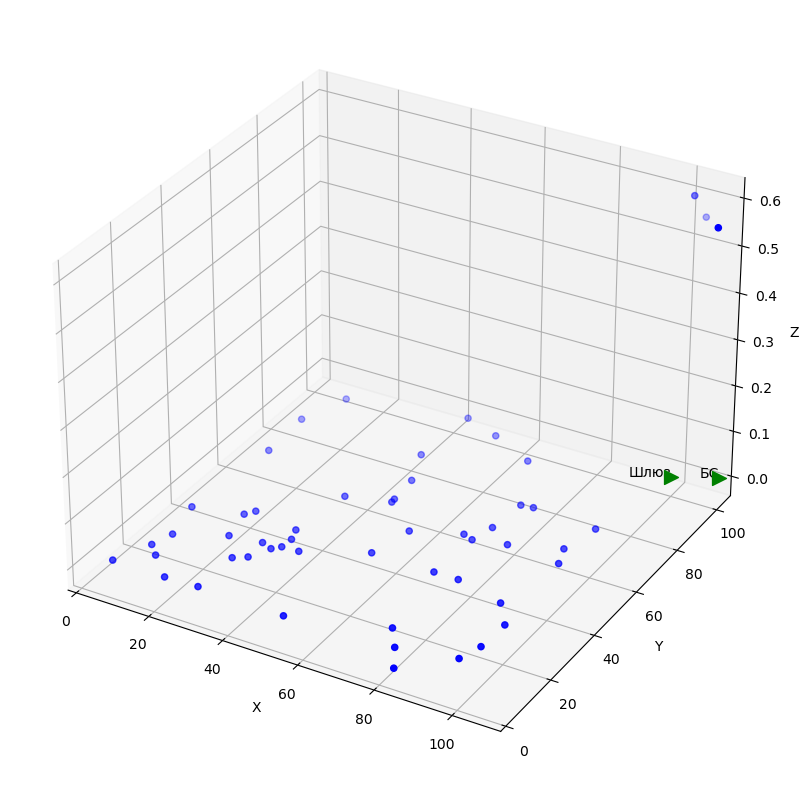

Iteration: 0
		 itr: 0
		 itr: 1
		 itr: 2
		 itr: 3
		 itr: 4
		 itr: 5
		 itr: 6
		 itr: 7
		 itr: 8
		 itr: 9
		 itr: 10
		 itr: 11
		 itr: 12
		 itr: 13
		 itr: 14


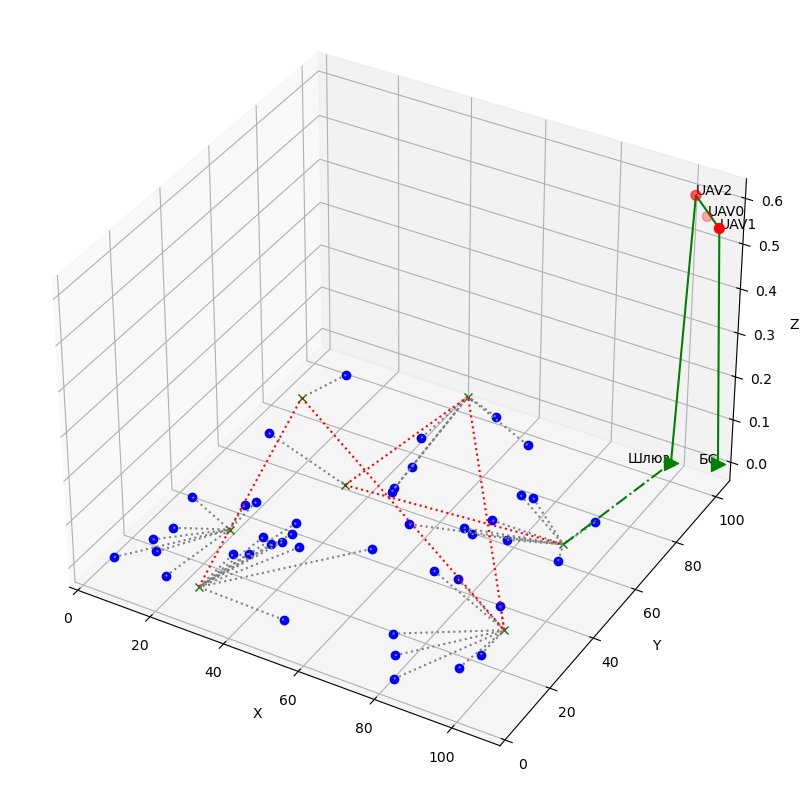

SRP [50.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
RRP [50.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
SDP [50.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.

 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


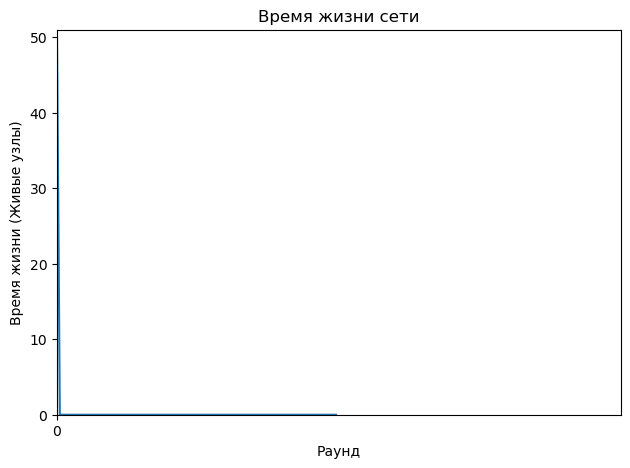

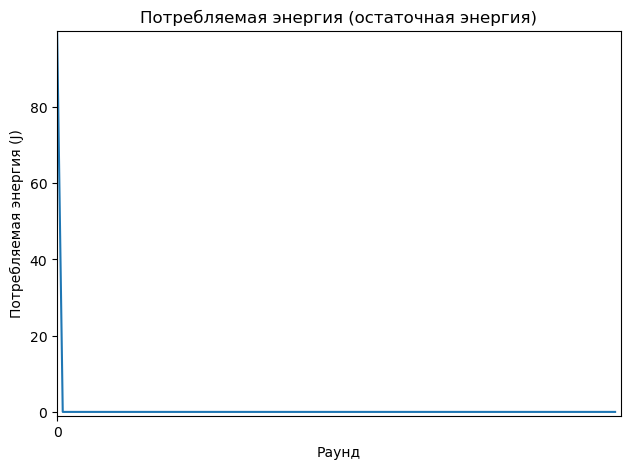

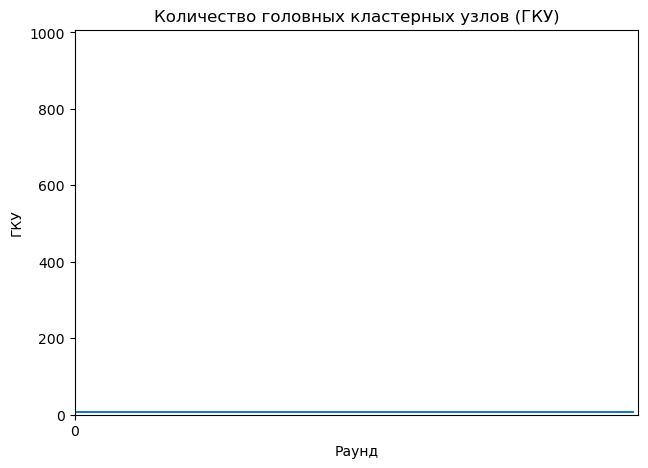

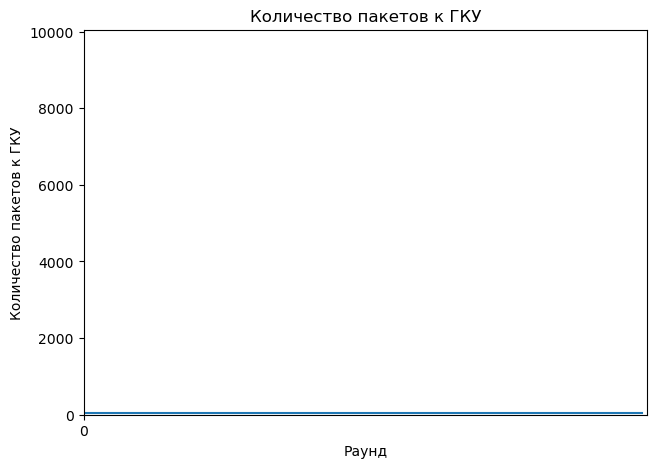

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8460\177522897.py:695: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.xlim([0, r])


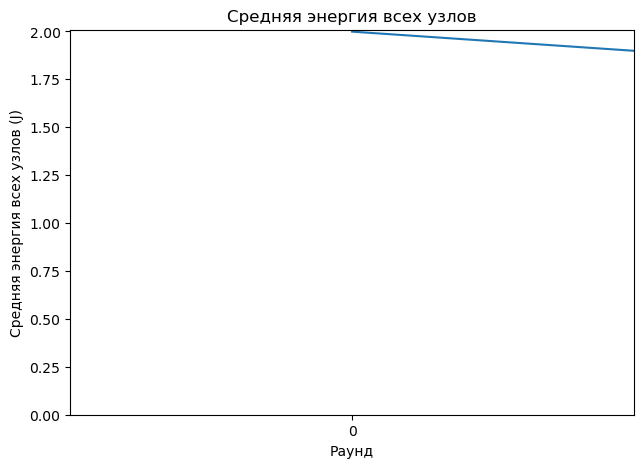

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8460\177522897.py:706: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.xlim([0, r])


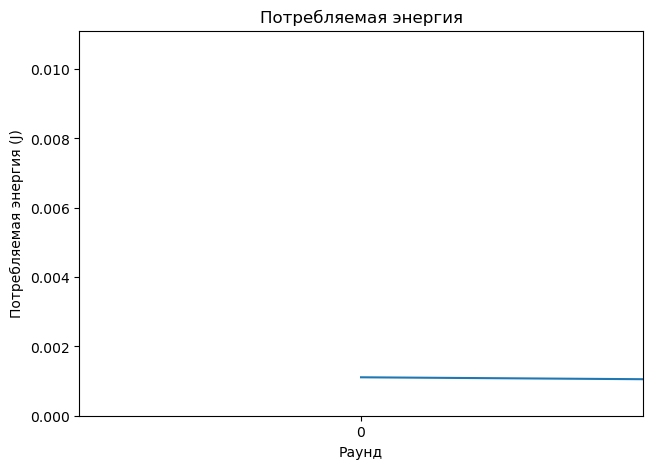

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8460\177522897.py:716: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.xlim([0,  r])


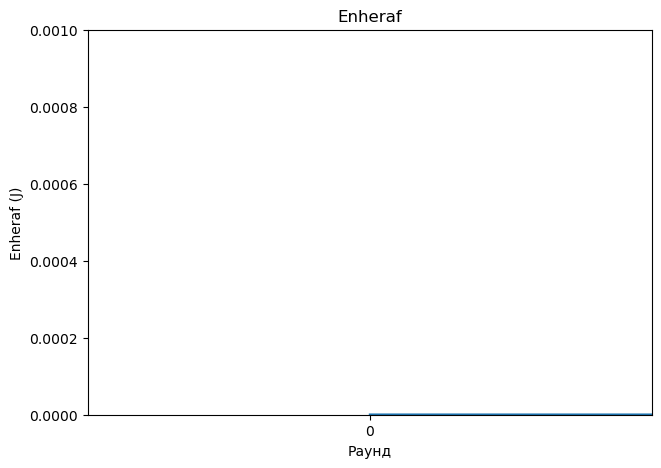

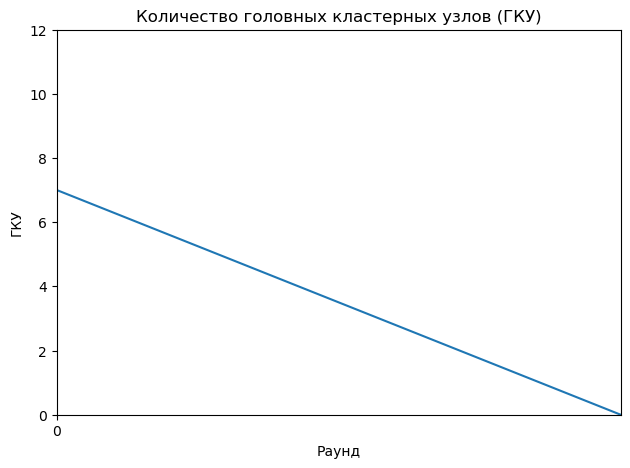

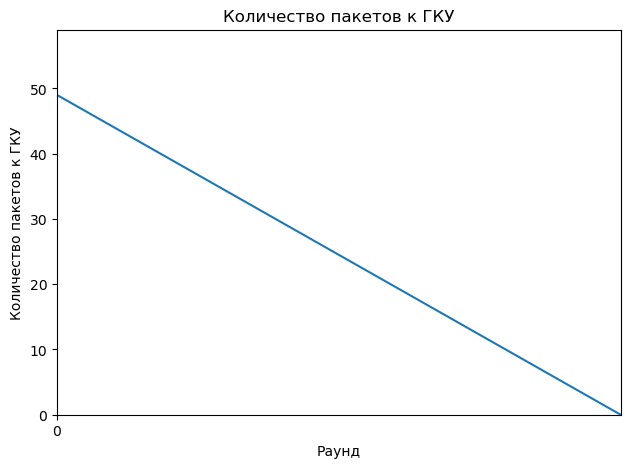

In [9]:
display(widgets.HTML(
    value=r'<p style="font-size:20px"><b>Программный комплекс МГБСС для моделирования гетерогенной БСС</b></p>',
))
items_layout = widgets.Layout( width='auto')
text_layout = widgets.Layout(width='60px')
box_layout = widgets.Layout(display='flex',
                    #flex_flow='column', 
                    align_items='stretch', 
                    border='solid 1px',
                    width='100%')
WSN_title = widgets.Label('Область НБСС ', layout = widgets.Layout( width='120px'))

lblAreaX = widgets.Label('X :', layout = widgets.Layout( width='20px'))
txtAreaX = widgets.Text(layout = text_layout)
lblAreaY = widgets.Label('Y :', layout = widgets.Layout( width='20px'))
txtAreaY = widgets.Text(layout = text_layout)
lblNumSensors = widgets.Label('Количество сенсоров в НБСС :', layout = widgets.Layout( width='200px'))
txtNumSensors = widgets.Text(layout = text_layout)
txtAreaUAVY = widgets.Text(layout = text_layout)

gateway_title = widgets.Label('Координаты шлюза ', layout = widgets.Layout( width='150px'))
lblGWX = widgets.Label('X :', layout = widgets.Layout( width='20px'))
txtGWX = widgets.Text(layout = text_layout)
lblGWY = widgets.Label('Y :', layout = widgets.Layout( width='20px'))
txtGWY = widgets.Text(layout = text_layout)


gwBox = widgets.HBox(children = [gateway_title, widgets.HBox(children = [lblGWX, txtGWX, lblGWY, txtGWY])])

items_WSN = [lblAreaX, txtAreaX, lblAreaY, txtAreaY, lblNumSensors,txtNumSensors]
WSN_box = widgets.VBox(children = [widgets.HBox(children = [WSN_title, widgets.HBox(children=items_WSN, layout=widgets.Layout(display='flex',
                    #flex_flow='column', 
                    align_items='stretch', 
                    border='solid 1px',
                    width='75%'))]), gwBox])
#display(WSN_box)

UAV_title = widgets.Label('Область БПЛА ', layout = widgets.Layout( width='120px'))
lblAreaUAVX = widgets.Label('X :', layout = widgets.Layout( width='20px'))
txtAreaUAVX = widgets.Text(layout = text_layout)
lblAreaUAVY = widgets.Label('Y :', layout = widgets.Layout( width='20px'))

lblAreaUAVZ = widgets.Label('Z :', layout = widgets.Layout( width='20px'))
txtAreaUAVZ = widgets.Label('500->600', layout = widgets.Layout( width='80px'), disabled=True)
lblNumUAVs = widgets.Label('Количество БПЛА :', layout = widgets.Layout( width='120px'))
txtNumUAVs = widgets.Text(layout = text_layout)

bs_title = widgets.Label('Координаты базовой станции ', layout = widgets.Layout( width='190px'))
lblBSX = widgets.Label('X :', layout = widgets.Layout( width='20px'))
txtBSX = widgets.Text(layout = text_layout)
lblBSY = widgets.Label('Y :', layout = widgets.Layout( width='20px'))
txtBSY = widgets.Text(layout = text_layout)
bsBox = widgets.HBox(children = [bs_title, widgets.HBox(children = [lblBSX, txtBSX, lblBSY, txtBSY])])

items_UAV = [lblAreaUAVX, txtAreaUAVX, lblAreaUAVY, txtAreaUAVY, lblAreaUAVZ, txtAreaUAVZ, lblNumUAVs, txtNumUAVs]
UAV_box = widgets.VBox(children = [widgets.HBox(children = [UAV_title, widgets.HBox(children=items_UAV, layout=widgets.Layout(display='flex',
                    #flex_flow='column', 
                    align_items='stretch', 
                    border='solid 1px',
                    width='75%'))]), bsBox])

#display(UAV_box)
#ploter(aliveSensors, "Yes")
lblclustering = widgets.Label('Методы маршрутизации в НБСС :', layout = widgets.Layout( width='220px'))
clustering_Dropdown = widgets.Dropdown(
                                    options=[('М К-средних c Хопфилда', 1)],
                                    value=1,
                                    layout = widgets.Layout( width='220px')
                                    )
box1 = widgets.VBox(children= [lblclustering, clustering_Dropdown])
lblRouting = widgets.Label('Методы маршрутизации в рое БПЛА :', layout = widgets.Layout( width='250px'))
Routing_Dropdown = widgets.Dropdown(
                                    options=[('Дейкстры', 1), ('Генетический алгоритм', 2)],
                                    value=2,
                                    layout = widgets.Layout( width='200px')
                                    )

box2 = widgets.VBox(children= [lblRouting, Routing_Dropdown])
algorithms_box = widgets.VBox(children =[box1, box2], layout = widgets.Layout(display='flex',
                    #flex_flow='column', 
                    align_items='stretch', 
                    border='solid 1px',
                    width='35%') ) #items_layout
#display(algorithms_box)

model_box = widgets.VBox(children =[WSN_box, UAV_box],  layout=widgets.Layout(display='flex',
                    #flex_flow='column', 
                    align_items='stretch', 
                    border='solid 1px',
                    width='65%'))
box_all = widgets.HBox(children =[model_box, algorithms_box])

btn_model = widgets.Button(description = "Старт")
btn_wsn_routing = widgets.Button(description = "plot WSN routing")
btn_uav_routing = widgets.Button(description = "plot UAV routing")
btn_box =  widgets.HBox(children = [btn_model])
display(box_all, btn_box)

lblKopt = widgets.Label('Оптимальное количество кластеров K =', layout = widgets.Layout( width='250px'))
lblKoptVal = widgets.Label('', layout = widgets.Layout( width='50px'))

lblWSNRoutingRes = widgets.Label('Путь данных в НБСС между ГКУ :', layout = widgets.Layout( width='220px'))
txtWSNRoutingRes = widgets.Label('', layout = widgets.Layout( width='auto'))

lblUAVRoutingRes = widgets.Label('Путь данных в рое БПЛА :', layout = widgets.Layout( width='200px'))
txtUAVRoutingRes = widgets.Label('', layout = widgets.Layout( width='auto'))


resultBox = widgets.VBox(children =[widgets.HBox(children =[lblKopt, lblKoptVal]),
              widgets.HBox(children =[lblWSNRoutingRes, txtWSNRoutingRes]),
              widgets.HBox(children =[lblUAVRoutingRes, txtUAVRoutingRes])], layout=box_layout)

lblRes = widgets.Label('Результаты :', layout = widgets.Layout( width='150px'))
res_box = widgets.VBox(children = [lblRes, resultBox])
display(res_box)

def plotModel(b):
    n = int(txtNumSensors.value)
    n_uav = int(txtNumUAVs.value)
    
    Area["x"] = int(txtAreaX.value)
    Area["y"] = int(txtAreaY.value)
    Area2["x"] = int(txtAreaUAVX.value)
    Area2["y"] = int(txtAreaUAVY.value)
    
    #Area2["z"] = int(lblAreaUAVY.value)
    Sinkx = int(txtGWX.value)
    Model["Sinkx"] = Sinkx
    Sinky = int(txtGWY.value)
    Model["Sinky"] = Sinky
    bs_X = int(txtBSX.value)
    Model["BsX"] = bs_X
    bs_Y = int(txtBSY.value)
    Model["BsY"] = bs_Y
    
    X_S = np.random.uniform(low = 0.0, high = Area["x"], size=(n,))
    #np.random.random_sample(size = n)* int(txtAreaX.value) #Area["x"]
    Y_S = np.random.uniform(low = 0.0, high = Area["y"], size=(n,))
    #np.random.random_sample(size = n)* int(txtAreaY.value)        
    X_U = np.random.uniform(low = Area["x"], high = Area2["x"] + Area["x"], size=(n_uav,))
    #np.random.random_sample(size = n)* int(txtNumUAVs.value) + int(txtAreaX.value) #Area["x"]
    Y_U = np.random.uniform(low = Area["y"], high = Area2["y"] + Area["y"], size=(n_uav,))
    #np.random.random_sample(size = n)* int(txtNumUAVs.value) + int(txtAreaY.value)
    Z_U = np.random.uniform(low=0.5, high=0.6, size=(n_uav,))
    
    names = []
    for i in range(len(X_U)):
        names.append('UAV'+str(i))
    save_DS_in_xlsx('Test_Uav_WSN.xlsx', X_U, Y_U, Z_U, names)
    
    read_file = pd.read_excel ("Test_Uav_WSN.xlsx")
    # into csv file
    read_file.to_csv ("Test_Uav_WSN.csv", 
                      index = None,
                      header=True)
    
    X = np.array(X_S)
    Y = np.array(Y_S)
    n=X.shape[0]                       #%Number of Nodes in the field
    setParameters(n)     		#%Set Parameters Sensors and Network
    #%%%%%%%%%%%%%%%%%%%%%%%%% configuration Sensors %%%%%%%%%%%%%%%%%%%%
    Sensors = ConfigureSensors(n,X,Y)
    Sensors[n]["xd"] =  Model["Sinkx"] #int(txtBSX.value)
    Sensors[n]["yd"] =  Model["Sinky"]  #int(txtBSY.value)
    BS = Sensors[n]
    Sink = [int(txtGWX.value), int(txtGWY.value), 0]

    #print('Sensors: ',len(Sensors))
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_S,Y_S, 0, c='blue', label = "Сенсор")
    ax.scatter(X_U,Y_U, Z_U, c='blue', label = "БПЛА")
    ax.scatter(int(txtGWX.value), int(txtGWY.value), 0, marker = '>', c='green', label = "Шлюз", s=100)
    #print('Шлюз(',int(txtGWX.value),',', int(txtGWY.value),')')
    ax.scatter(int(txtBSX.value), int(txtBSY.value), 0, marker = '>', c='green', label = "БС", s=100)
    #print('БС(',int(txtBSX.value),',', int(txtBSY.value),')')
    ax.text(int(txtGWX.value), int(txtGWY.value), 0, "Шлюз", zorder=1,  color='k', ha='right')
    ax.text(int(txtBSX.value), int(txtBSY.value), 0, "БС", zorder=1,  color='k', ha='right')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')  
    plt.ylim([0, int(txtAreaY.value) + int(txtAreaUAVY.value)])
    plt.xlim([0, int(txtAreaX.value) + int(txtAreaUAVX.value)])
    plt.show()
    
    #print(Sensors)
    #print(" Running WSN Routing")
    Model["rmax"] = 100
    #%%%%%%%%%%%%%%%%%%%%%%%%%% Parameters initialization %%%%%%%%%%%%%%%%
    countCHs=0;         #%counter for CHs
    flag_first_dead=0;  #%flag_first_dead
    deadNum=0;          #%Number of dead nodes
    initEnergy=0;       #%Initial Energy
    for i in range(n):
        initEnergy = Sensors[i]["E"] + initEnergy
    SRP = np.zeros((1,Model["rmax"]))[0]  #%number of sent routing packets
    RRP = np.zeros((1,Model["rmax"]))[0] #%number of receive routing packets
    SDP = np.zeros((1,Model["rmax"]))[0]  # %number of sent data packets 
    RDP = np.zeros((1,Model["rmax"]))[0]  # %number of receive data packets
    Sum_DEAD = np.zeros((1,Model["rmax"]))[0]
    CLUSTERHS = np.zeros((1,Model["rmax"]))[0]
    #=== Statictics =======
    AllSensorEnergy = np.zeros((1,Model["rmax"]))[0]
    AliveSensors = np.zeros((1,Model["rmax"]))[0]
    SumEnergyAllSensor = np.zeros((1,Model["rmax"]))[0]
    AvgEnergyAllSensor = np.zeros((1,Model["rmax"]))[0]
    ConsumEnergy = np.zeros((1,Model["rmax"]))[0]
    Enheraf = np.zeros((1,Model["rmax"]))[0]
    packets_TO_BS = np.zeros((1,Model["rmax"]))[0]
    packets_TO_CH = np.zeros((1,Model["rmax"]))[0]
    ######################### Start Simulation #########################
    #global srp,rrp,sdp,rdp, ptb, ptc
    srp = 0   #%counter number of sent routing packets
    rrp = 0   #%counter number of receive routing packets
    sdp = 0   #%counter number of sent data packets
    rdp = 0   #%counter number of receive data packets
    ptb = 0 # counter number of sent packets to BS
    ptc = 0 # counter number of sent packets to CH
    ##################
    #del Sensors[-1]
    aliveSensors = Sensors
    sinkXY = [aliveSensors[-1]["xd"], aliveSensors[-1]["yd"]]
    R = 100 #normalizeRange(minField, maxField, 0, 1, 100)
    center = int(txtAreaX.value) / 2
    ######################### Sink_WSN broadcast start message to all ground sensors #########################
    #print("Alive sensors : ", aliveSensors[n])
    # sink send broadcat to nearest nodes

    Receiver = [i for i in range(n)] # %All nodes
    #print('Receiver: ', Receiver)

    ### new way #####
    for i in Receiver:
        if (aliveSensors[i]["E"] > 0):
            #### receiving Hello from BS ###
            aliveSensors[i]["E"] = aliveSensors[i]["E"] - ((Model["ERX"] + Model["EDA"]) * 100)
            srp += 1
            rrp += 1   # increase number of recieve routing packets
            #### sending Locations to BS ###
            distance = np.sqrt(np.square(aliveSensors[i]["xd"] - Sensors[-1]["xd"]) + np.square(aliveSensors[i]["yd"] - Sensors[-1]["yd"]))
            if (distance > Model["do"]):
                 aliveSensors[i]["E"] = aliveSensors[i]["E"] - (Model["ETX"] * 4000 + Model["Emp"] * 4000 * (distance ** 4))
            else:
                 aliveSensors[i]["E"] = aliveSensors[i]["E"] - (Model["ETX"] * 4000 + Model["Efs"] * 4000 * (distance ** 2))
            sdp += 1 # # increase number of sent data packets
            ptb += 1 # packets to BS
            rdp += 1 # BS receive data packets
    ### end new way ###
    #Sensors = SendReceivePackets(Sensors,Sender,'Hello',Receiver)
    #print("BS sent broadcast commands to all sensors for sending their locations")
    #print("All sensors sent packets to BS with their location and radio matrix")

    #Save metrics
    SRP[0] = srp
    RRP[0] = rrp
    SDP[0] = sdp
    RDP[0] = rdp
    packets_TO_BS[0] = ptb
    packets_TO_CH[0] = ptc

    # run elbow/k-means and get clusters without centroids
    n_samples = len(aliveSensors)-1 #X.shape[0]  without BS
    z = np.zeros([n_samples,1])
    samples = np.zeros([n_samples,3])

    for i in range(n_samples):
        samples[i][0] = aliveSensors[i]["xd"]
        samples[i][1] = aliveSensors[i]["yd"]
        samples[i][2] = z[i]
    aliveSensors = resetType(aliveSensors)
    TotalCH, members, aliveSensors = KmeansSelectCH(samples, aliveSensors, R, center, 100) #TotalCH is a list of indecis of sensors that are cH
    #print('TotalCH = ', TotalCH)
    lblKoptVal.value = str(len(TotalCH))
    #--------------- K-means and Hopfeild ------------
    ##################################################
    for r in range(1): #Model["rmax"]
        #print("------- Round ", r , " --------")
        numDead, aliveSensors, Sensors = checkAliveSensors(aliveSensors, Sensors)
        #deadNum = ploter(aliveSensors, "No")
        aliveSensors = resetType(aliveSensors)
        for m in members:
            if m == []:
                 members.remove(m)
        for mc, memberCluster in enumerate(members):
            for s, sens in enumerate(memberCluster):
                if Sensors[sens]["E"] <= 0 :
                    memberCluster.remove(sens)
        #print('\nКоличество живых датчиков: ', len(aliveSensors) - deadNum -1)

        if len(aliveSensors) <= 1:
            break
        ############################ Initialization #####################
        #member = []
        countCHs = 0
        #counter for bit transmitted to Bases Station and Cluster Heads
        srpp = 0
        rrpp = 0
        sdpp = 0
        rdpp = 0
        ptbb = 0
        ptcc = 0
        #time.sleep(0.001) # pause
        #####################################################################
        # set CH from members
        TotalCH = []
        for mc, memberCluster in enumerate(members):
            if memberCluster != []:
                i = (r-1) % len(memberCluster)
                new_ch = memberCluster[i]
                TotalCH.append(new_ch)
                aliveSensors[new_ch]["type"] = 'C'
                # set CH for each sensor in the cluster
                for s in memberCluster:
                    #print("s: ", s, " new_ch:", new_ch)
                    if s != new_ch:
                        aliveSensors[s]["MCH"] = aliveSensors[new_ch]["id"]
        # print("\nНомер узлов в качестве ГКУ: ", TotalCH)
        countCHs = len(TotalCH)

        ############### BS sent broadcast to all sensors with CH and members info #######
        Sender = len(aliveSensors)-1 # BS or sink
        #------- new way -----
        Receiver = [i for i in range(len(aliveSensors)-1)]
        
        for i in Receiver:
            if (aliveSensors[i]["E"] > 0):
                #### receiving Hello from BS ###
                aliveSensors[i]["E"] = aliveSensors[i]["E"] - ((Model["ERX"] + Model["EDA"]) * 100)
                srpp += 1
                rrpp += 1   # increase number of recieve routing packets
        
        #------- end way -----
        #print("BS sent broadcast command packets to all sensors with information about CH and members")
        #################################### All sensor send data packet to  CH
        NumPacket = Model["NumPacket"]
        #------ new way ----
        for j, ch in enumerate(TotalCH): # list of indeces of ch
            #print("\t\t ch:", ch, " | aliveSensors[ch]:", aliveSensors[ch]["id"], " | E: ", aliveSensors[ch]["E"])
            activeNodesIncluster = []
            sleepingNodes = []
            if members[j] != []:
                n_sleeping_nodes = 0 # int(len(members[j]) / 2)
                if len(members[j]) > n_sleeping_nodes and n_sleeping_nodes > 0:
                    for sn in range(n_sleeping_nodes):
                        sleep_node = random.choice(members[j]) # choose random node to put it sleep
                        while sleep_node in sleepingNodes:
                            sleep_node = random.choice(members[j])
                        sleepingNodes.append(sleep_node)
                    for actvN in (members[j]):
                        if actvN not in sleepingNodes:
                            activeNodesIncluster.append(actvN)  # members[j].pop()
                else:
                    activeNodesIncluster = members[j]
                
                for idm, mem in enumerate(activeNodesIncluster): # # list of indeces of members   members[j]
                    if ch != mem:
                        for i, s in enumerate(aliveSensors):
                            if s["id"] == mem:
                                indx_mem = i  
                        #print("\t\t indx_mem:", indx_mem, " | aliveSensors[indx_mem]:", aliveSensors[indx_mem]["id"], " | E: ", aliveSensors[indx_mem]["E"])
                        if (aliveSensors[ch]["E"] > 0 and aliveSensors[indx_mem]["E"] > 0):
                            distance = np.sqrt(np.square(aliveSensors[ch]["xd"] - aliveSensors[indx_mem]["xd"]) + np.square(aliveSensors[ch]["yd"] - aliveSensors[indx_mem]["yd"]))
                            #### sending data from members to CHs ###
                            if (distance > Model["do"]):
                                aliveSensors[indx_mem]["E"] = aliveSensors[indx_mem]["E"] - (Model["ETX"] * 4000 + Model["Emp"] * 4000 * (distance ** 4))
                            else:
                                aliveSensors[indx_mem]["E"] = aliveSensors[indx_mem]["E"] - (Model["ETX"] * 4000 + Model["Efs"] * 4000 * (distance ** 2))
                            sdpp += 1 # # increase number of sent data packets
                            ptcc += 1 # packets to CH
                            #### CHs receive Data from members ###
                            aliveSensors[ch]["E"] = aliveSensors[ch]["E"] - ((Model["ERX"] + Model["EDA"]) * 4000)                
                            rdpp += 1   # increase number of recieve data packets

            """ #### old ####
            activeNodesIncluster = []
            sleepingNodes = []
            if members[j] != []:
                for idm, mem in enumerate(members[j]): # # list of indeces of members
                    if ch != mem:
                        for i, s in enumerate(aliveSensors):
                            if s["id"] == mem:
                                indx_mem = i  
                        #print("\t\t indx_mem:", indx_mem, " | aliveSensors[indx_mem]:", aliveSensors[indx_mem]["id"], " | E: ", aliveSensors[indx_mem]["E"])
                        if (aliveSensors[ch]["E"] > 0 and aliveSensors[indx_mem]["E"] > 0):
                            distance = np.sqrt(np.square(aliveSensors[ch]["xd"] - aliveSensors[indx_mem]["xd"]) + np.square(aliveSensors[ch]["yd"] - aliveSensors[indx_mem]["yd"]))
                            #### sending data from members to CHs ###
                            if (distance > Model["do"]):
                                aliveSensors[indx_mem]["E"] = aliveSensors[indx_mem]["E"] - (Model["ETX"] * 4000 + Model["Emp"] * 4000 * (distance ** 4))
                            else:
                                aliveSensors[indx_mem]["E"] = aliveSensors[indx_mem]["E"] - (Model["ETX"] * 4000 + Model["Efs"] * 4000 * (distance ** 2))
                            sdpp += 1 # # increase number of sent data packets
                            ptcc += 1 # packets to CH
                            #### CHs receive Data from members ###
                            aliveSensors[ch]["E"] = aliveSensors[ch]["E"] - ((Model["ERX"] + Model["EDA"]) * 4000)                
                            rdpp += 1   # increase number of recieve data packets
            """
        #------ end new way -----
        #print("Sensors sent data packet to CHs")
        ############# calculate distance between CHs and sink and find closet CH to BS #############
        minDist = np.sqrt(np.square(aliveSensors[TotalCH[0]]["xd"] - Model["Sinkx"]) + np.square(aliveSensors[TotalCH[0]]["yd"] - Model["Sinky"]))
        maxDst = 0
        indexCHFarFromBS = n
        indxChClosetToBS = TotalCH[0]
        #TotalCH = np.array(TotalCH)
        ndx = 0
        for i, ch in enumerate(TotalCH):
            #print('ГКУ ',i,'(', aliveSensors[ch]["xd"], ', ', aliveSensors[ch]["yd"], ')')
            dcb = np.sqrt(np.square(aliveSensors[ch]["xd"] - Model["Sinkx"]) + np.square(aliveSensors[ch]["yd"] - Model["Sinky"]))
            aliveSensors[ch]["dis2sink"] = dcb
            if aliveSensors[ch]["dis2sink"] < minDist:
                minDist = aliveSensors[ch]["dis2sink"]
                indxChClosetToBS = ch
            if aliveSensors[ch]["dis2sink"] > maxDst:
                maxDst = aliveSensors[ch]["dis2sink"]
                indexCHFarFromBS = ch        
        
        """ ### OLD #####
        minDist = np.sqrt(np.square(aliveSensors[TotalCH[0]]["xd"] - Model["Sinkx"]) + np.square(aliveSensors[TotalCH[0]]["yd"] - Model["Sinky"]))
        indxChClosetToBS = TotalCH[0]
        #TotalCH = np.array(TotalCH)
        ndx = 0
        for i, ch in enumerate(TotalCH):
            #print('ГКУ ',i,'(', aliveSensors[ch]["xd"], ', ', aliveSensors[ch]["yd"], ')')
            dcb = np.sqrt(np.square(aliveSensors[ch]["xd"] - Model["Sinkx"]) + np.square(aliveSensors[ch]["yd"] - Model["Sinky"]))
            aliveSensors[ch]["dis2sink"] = dcb
            if aliveSensors[ch]["dis2sink"] < minDist:
                minDist = aliveSensors[ch]["dis2sink"]
                indxChClosetToBS = ch
        ### END OLD #####
        """
        #prnt('\nБлижайшей ГКУ к шлюзу: ', aliveSensors[indxChClosetToBS]["id"])
        ############## run hopfield ############### 
        #print("befor run hopfield 'TotalCH' : ", TotalCH)
        #for ch in TotalCH:
         #    print("(",Sensors[ch]["xd"][0],", ", Sensors[ch]["yd"][0], ")")
        ###### OLD #####
        nodes = set_UAVS(aliveSensors, TotalCH) #/100 # nodes in format (x,y)#----------------------------------
        nodes = normalizeRange(0, 100, 0, 0.1, nodes)
        #print(nodes)
        m = len(TotalCH)
        #d = calc_d(nodes, [sinkXY[0]/100, sinkXY[1]/100], R/100) # -----------------------------------------------------
        d = calc_d(nodes, [normalizeRange(0, 100, 0, 0.1, sinkXY[0]), normalizeRange(0, 100, 0, 0.1, sinkXY[1])], normalizeRange(0, 100, 0, 0.1, R))
        #print('D = ', d)
        summation = 0
        mini = 1000
        maxi = -1
        final_v = np.zeros([m, m])
        start_time = time.time()
        for iteration in range(1):
            print("Iteration:", iteration)
            hp = Hopfield(m, d, 100.0)
            #v = hp.modifyU(A=100.0, B=100.0, C=95.0, D=110.0, sigma=1, iterations=1000)
            v = hp.predict(A=100.0, B=100.0, C=90.0, D=110.0, max_iterations=1000)        
            dist = 0
            prev_row = -1
            for col in range(v.shape[1]):
                for row in range(v.shape[0]):
                    if v[row][col] == 1:
                        if prev_row != -1:
                            dist += d[prev_row][row]
                        prev_row = row
                        break    
            if mini > dist:
                final_v = v
                mini = dist
            #print('\tDis: \t', dist)
        #print("\nMin Distance: {}\nV:\n{}".format(mini, final_v))
        prev_row = -1
        indxCHpath = [] # list of indecis sensors that are CH forming path
        for col in range(final_v.shape[1]):
            for row in range(final_v.shape[0]):
                if final_v[row][col] == 1:
                    if prev_row != -1:
                        indxCHpath.append(prev_row)
                    prev_row = row            
                    break 
        indxCHpath.append(prev_row)
        idCH = []
        for i in indxCHpath:
            idCH.append(TotalCH[i])
        #print('idCH ', idCH)
        for i in range(len(idCH)-1):
            #aliveSensors[idCH[i]]["MCH"] = idCH[i+1]
            aliveSensors[idCH[i]]["dis2ch"] = np.sqrt(np.square(aliveSensors[idCH[i+1]]["xd"] - aliveSensors[idCH[i]]["xd"]) + np.square(aliveSensors[idCH[i+1]]["yd"] - aliveSensors[idCH[i]]["yd"]))
        end_time = time.time()        
        pahtS = ""
        if aliveSensors[idCH[0]]["dis2sink"] < aliveSensors[idCH[len(idCH)-1]]["dis2sink"]:
            for i in range(len(idCH)-1, -1, -1): 
                if i == 0:
                    aliveSensors[idCH[i]]["MCH"] = n
                    pahtS += str(idCH[i]) + " -> " + str(n)
                else:
                    aliveSensors[idCH[i]]["MCH"] = idCH[i-1]
                    pahtS += str(idCH[i]) + " -> "
        else:
            for i in range(len(idCH)):
                if i == len(idCH)-1:
                    aliveSensors[idCH[i]]["MCH"] = n
                    pahtS += str(idCH[i]) + " -> " + str(n)
                else:
                    aliveSensors[idCH[i]]["MCH"] = idCH[i+1]
                    pahtS += str(idCH[i]) + " -> "
        
        
        """
        for i in range(len(idCH)-1, -1, -1):
            if i == 0:
                pahtS += str(idCH[i]) + " -> " + '100'
            else:
                pahtS += str(idCH[i]) + " -> "
        """   
        #print("\nНеобходимое время для наождения пути данных между ГКУ: ", end_time - start_time)
        #print("\nПуть передачи данных между ГкУ :\n", pahtS)
        txtWSNRoutingRes.value = pahtS
        Sender = len(aliveSensors)-1 # BS or sink
        recvs = []
        for ch in TotalCH:
            recvs.append(aliveSensors[ch]["id"])
        #nearestRecToBS = findReceiver(aliveSensors ,Sender ,aliveSensors[Sender]["RR"])
        #print('nearestRecToBS', nearestRecToBS)
        
        totalCHWithSink = TotalCH + [n]
        
        for j,icp in enumerate(indxCHpath):
            if aliveSensors[totalCHWithSink[icp]]["E"] > 0:
                indx_currentHop = totalCHWithSink[icp]
                id_nextHop = aliveSensors[totalCHWithSink[icp]]["MCH"]
                for indx, sen in enumerate(aliveSensors):
                    if sen["id"] == id_nextHop:
                        indx_nextHop = indx
                distance = np.sqrt(np.square(aliveSensors[indx_currentHop]["xd"] - aliveSensors[indx_nextHop]["xd"]) + np.square(aliveSensors[indx_currentHop]["yd"] - aliveSensors[indx_nextHop]["yd"]))
                #### sending data from current_CH to next_CH ###
                if (distance > Model["do"]):
                    aliveSensors[indx_currentHop]["E"] = aliveSensors[indx_currentHop]["E"] - (Model["ETX"] * 4000 + Model["Emp"] * 4000 * (distance ** 4))
                else:
                    aliveSensors[indx_currentHop]["E"] = aliveSensors[indx_currentHop]["E"] - (Model["ETX"] * 4000 + Model["Efs"] * 4000 * (distance ** 2))
                if id_nextHop != Model["n"]: # Bs not consume energy only next_CH when receiving data
                    aliveSensors[indx_nextHop]["E"] = aliveSensors[indx_nextHop]["E"] - ((Model["ERX"] + Model["EDA"]) * 4000)
                    rdpp += 1
                if id_nextHop == Model["n"]:
                    ptbb += 1
                else:
                    ptcc += 1 # packets to CH
                sdpp += 1 # # increase number of sent data packets
                #### current_CH receive Data from previous_CH ###
                if j > 0: #  first CH does not receive data
                    aliveSensors[indx_currentHop]["E"] = aliveSensors[indx_currentHop]["E"] - ((Model["ERX"] + Model["EDA"]) * 4000)                
                    rdpp += 1   # increase number of recieve data packets
        #print("BS sent broadcast command packets to all CHs with information about path between CHs") 
        ############# End Hopfield ###############################
        #print(aliveSensors)
        #===================================================ploter(aliveSensors, "Yes")
        ######################################################
        #       Routing in LSS using GA
        #####################################################
        mainProg = MainProgram()
        UAV_file_name = 'Test_Uav_WSN.xlsx' #'UAV_10_GA.xlsx'
        CH_xlsx_file_name = 'Test_Uav_WSN.xlsx' #'UAV_10_GA.xlsx'
        CH_csv_file_name = 'Test_Uav_WSN.csv' #'./UAV_10_GA.csv'

        scores, pathUAV = mainProg.start(UAV_file_name, UAV_file_name, CH_csv_file_name, aliveSensors)
        txtUAVRoutingRes.value = pathUAV
        
        
        ## STATISTICS
        Sum_DEAD[r] = deadNum
        #print("SRP, RRP, SDP, RDP: ", srpp, rrpp, sdpp, rdpp)
        SRP[r] = srpp
        RRP[r] = rrpp
        SDP[r] = sdpp
        RDP[r] = rdpp
        packets_TO_BS[r] = ptbb
        packets_TO_CH[r] = ptcc
        CLUSTERHS[r] = countCHs
        alive = 0
        SensorEnergy = 0
        for i in range(len(Sensors)-1):
            if Sensors[i]["E"] > 0:
                alive = alive + 1
                SensorEnergy = SensorEnergy + Sensors[i]["E"]
        if alive == 0:
            break
        AliveSensors[r] = alive
        SumEnergyAllSensor[r] = SensorEnergy
        AvgEnergyAllSensor[r] = SensorEnergy / alive
        ConsumEnergy[r] = (initEnergy - SumEnergyAllSensor[r]) / n

        En = 0
        for i in range(len(Sensors)-1):
            if Sensors[i]["E"] > 0:
                En = En + np.square(Sensors[i]["E"] - AvgEnergyAllSensor[r])
        Enheraf[r] = En / alive
        #plt.title(sprintf('Round=%d,Dead nodes=%d',r + 1,deadNum))
        #dead
        if (n == deadNum):
            lastPeriod = r
            break
        #print("live sensors: ", aliveSensors)
        
        STATISTICS = {"SRP": SRP,
                      "RRP": RRP,
                      "SDP": SDP,
                      "RDP": RDP,
                      "packets_TO_CH": packets_TO_CH,
                      "packets_TO_BS": packets_TO_BS,
                      "CLUSTERS": CLUSTERHS,
                      "sum_dead_nodes": Sum_DEAD,
                      "Alive Sensors": AliveSensors,
                      "Avg_energy_all_nodes": AvgEnergyAllSensor,
                      "Sum energy all nodes": SumEnergyAllSensor,
                      "Consumed Energy": ConsumEnergy,
                      "Enheraf": Enheraf
                     }
        
        print("SRP", SRP)
        print("RRP", RRP)
        print("SDP", SDP)
        print("RDP", RDP)
        print('packets_TO_CH', packets_TO_CH)
        print('packets_TO_BS', packets_TO_BS)
        print('sum dead nodes', Sum_DEAD)
        print('Alive Sensors', AliveSensors)
        print('energy_all_nodes', AllSensorEnergy)
        print('Sum energy all nodes', SumEnergyAllSensor)
        print("Clusters in each Round: ", CLUSTERHS) # 
        print("Avg Energy All nodes: ", AvgEnergyAllSensor)
        print("ConsumEnergy: ", ConsumEnergy) # ConsumEnergy
        print("Enheraf: ", Enheraf)
        
        
        saveStatistics('STATISTICS.xlsx', "OUT", STATISTICS) 
        #for j,statis in enumerate(STATISTICS):
        #    print(statis, " | ", STATISTICS[statis])

        #######################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        plt.ylim([0, max(AliveSensors)+1])
        plt.xlim([0, r+200])
        plt.plot(AliveSensors)
        plt.xlabel("Раунд")
        plt.ylabel("Время жизни (Живые узлы)")
        plt.title("Время жизни сети")
        ax.set_xticks(np.arange(0, r+200, 2000))
        plt.show()
        #################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        plt.xlim([0,  r+100])
        plt.ylim([-1, max(SumEnergyAllSensor)])
        plt.plot(SumEnergyAllSensor)
        plt.title("Потребляемая энергия (остаточная энергия)")
        plt.xlabel("Раунд")
        plt.ylabel("Потребляемая энергия (J)")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()
        #################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        sumPkt = 0
        all_ch = []
        for ch in CLUSTERHS:
            sumPkt += ch
            all_ch.append(sumPkt)
        plt.plot(all_ch)
        plt.xlim([0,  r+100])
        plt.ylim([0, max(all_ch)+1000])
        plt.xlabel("Раунд")
        plt.ylabel("ГКУ")
        plt.title("Количество головных кластерных узлов (ГКУ)")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()
        ####################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        sumPkt = 0
        all_pkt = []
        for pkt in packets_TO_CH:
            sumPkt += pkt
            all_pkt.append(sumPkt)
        plt.xlim([0,  r+100]) # Model["rmax"]
        plt.ylim([0, max(all_pkt)+10000]) # max(packets_TO_CH) max(packets_TO_CH)+1
        plt.plot(all_pkt)
        plt.xlabel("Раунд")
        plt.ylabel("Количество пакетов к ГКУ")
        plt.title("Количество пакетов к ГКУ")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()
        ###################################################
        #######################################################
        AvgEnergyAllSensor
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        plt.ylim([0, max(AvgEnergyAllSensor) + 0.01])
        plt.xlim([0, r])
        plt.plot(AvgEnergyAllSensor)
        plt.xlabel("Раунд")
        plt.ylabel("Средняя энергия всех узлов (J)")
        plt.title("Средняя энергия всех узлов")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()
        ##################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        plt.ylim([0, max(ConsumEnergy)+ 0.01])
        plt.xlim([0, r])
        plt.plot(ConsumEnergy)
        plt.xlabel("Раунд")
        plt.ylabel("Потребляемая энергия (J)")
        plt.title("Потребляемая энергия")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()
        #################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        plt.xlim([0,  r])
        plt.ylim([0, max(Enheraf)+0.001])
        plt.plot(Enheraf)
        plt.title("Enheraf")
        plt.xlabel("Раунд")
        plt.ylabel("Enheraf (J)")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()
        #################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        sumPkt = 0
        all_ch = []
        for ch in CLUSTERHS:
            sumPkt += ch
            all_ch.append(sumPkt)
        plt.plot(CLUSTERHS)
        plt.xlim([0,  r+1])
        plt.ylim([0, max(CLUSTERHS)+5])
        plt.xlabel("Раунд")
        plt.ylabel("ГКУ")
        plt.title("Количество головных кластерных узлов (ГКУ)")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()
        ####################################################
        fig = plt.figure(figsize=(16, 5))
        ax = fig.add_subplot(121)
        sumPkt = 0
        all_pkt = []
        for pkt in packets_TO_CH:
            sumPkt += pkt
            all_pkt.append(sumPkt)
        plt.xlim([0,  r+1]) # Model["rmax"]
        plt.ylim([0, max(packets_TO_CH)+10]) # max(packets_TO_CH) max(packets_TO_CH)+1
        plt.plot(packets_TO_CH)
        plt.xlabel("Раунд")
        plt.ylabel("Количество пакетов к ГКУ")
        plt.title("Количество пакетов к ГКУ")
        ax.set_xticks(np.arange(0, r+200, 1000))
        plt.show()            
        
btn_model.on_click(plotModel)


# Print dependences

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

numpy     : 1.21.5
matplotlib: 3.5.2
csv       : 1.0
pandas    : 1.4.4
xlsxwriter: 3.0.3
ipywidgets: 8.0.3
IPython   : 7.31.1
watermark : 2.4.3

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores   : 4
Architecture: 64bit

 
Last updated: Mon Jan 08 2024 19:09:06Russia TZ 2 Standard Time

